In [5]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image

In [7]:
#경로 지정
train_dir = 'data/Training'
test_dir = 'data/Testing'

In [8]:
#레이블 값 (classes)
classes = os.listdir(train_dir)
print(classes)

['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']


In [9]:
#VGG-16, vit (전처리)
resize_size = 256
crop_size = 224

def preprocess_image(image):
    image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR) #크기 조절
    image = tf.image.central_crop(image, central_fraction=crop_size / resize_size) #중앙 224x224
    image = tf.math.divide(image, 255.0) #normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std #다 normalize

    return image

In [10]:
from sklearn.preprocessing import LabelEncoder

X = [] #Image
y = [] #class
for i in classes:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j)) #이미지 읽기
        img = preprocess_image(img) #전처리
        X.append(img) #X list 넣고
        y.append(i) # y list
X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical([classes.index(label) for label in y]) #문자열 -> [0,3]

  0%|                                           | 1/395 [00:00<00:51,  7.66it/s]

Metal device set to: Apple M2 Pro


100%|████████████████████████████████████████| 827/827 [00:03<00:00, 233.48it/s]


In [11]:
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size=0.2,random_state=101) #training 분할 (train,val)

In [12]:
X_test = []
y_test = []
for i in classes:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = preprocess_image(img)
        X_test.append(img)
        y_test.append(i)
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = tf.keras.utils.to_categorical([classes.index(label) for label in y_test]) #testing -> testset

100%|██████████████████████████████████████████| 74/74 [00:00<00:00, 181.57it/s]


In [13]:
#data augmentation 아직 적용 안햇음.
#augmentation은 어떻게 하면 좋을지..? -> 고민해주시면 좋을 것 같습니다...... 코드 짜서 주시면 좋을거같습니당....
# img_datagen = ImageDataGenerator(
#     rotation_range=30,
#     rescale = 1./255.,
#     width_shift_range = 0.3,
#     height_shift_range = 0.3,
#     shear_range = 0.3,
#     zoom_range = 0.3,
#     horizontal_flip = True,
#     vertical_flip = True)

# img_datagen.fit(X_train)

In [14]:
#그래프 그려주는 거 (성능 그래프)
def plot_acc_model(acc, val_acc, epochs):
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    
def plot_loss_model(loss, val_loss, epochs):
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [16]:
#VGG16, imagenet에 대해서 사전학습된거, 224x224 -> Input, layer.trainable -> 사전학습된 모델이어서 처음에는 가중치 false 학습이 안되어서
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

In [17]:
x = Flatten()(base_model.output)
#class가 4개라서
output = Dense(4, activation='softmax')(x)

In [18]:
#파라미터 튜닝 : learning_rate 부분 값 수정, optimizer -> 다른 optimizer 사용, loss = 다른 loss 사용.
model_vgg16 = Model(inputs=base_model.input, outputs=output)
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)
model_vgg16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
from keras.callbacks import EarlyStopping

#학습 -> earlystopping, patience = 10 -> validation loss이 원래 최소값보다 큰애들이 10번이상 나오면 종료되는 조건
#paramter tuning : early_stopping : patience 값 조정, epochs = 값 늘려보기.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
#학습시키는거 (epoch = 몇번 학습시킬지)
history = model_vgg16.fit(X_train, y_train,
                          epochs=1,
                          validation_data=(X_val, y_val),
                          verbose=1,
                          callbacks=[early_stopping])

2023-11-02 16:40:02.579781: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


72/72 [==============================] - 23s 309ms/step - loss: 1.1010 - accuracy: 0.5375 - val_loss: 0.8158 - val_accuracy: 0.6446


In [21]:
#학습 성능 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

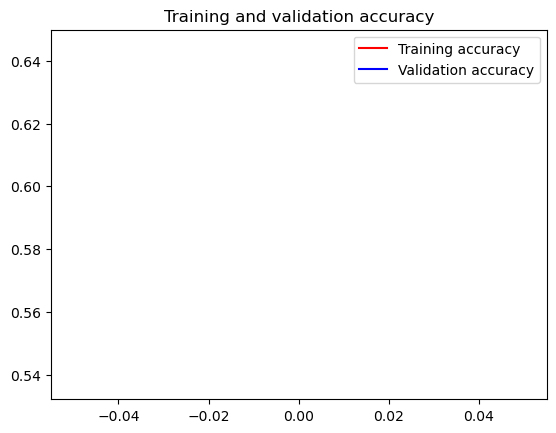

<Figure size 640x480 with 0 Axes>

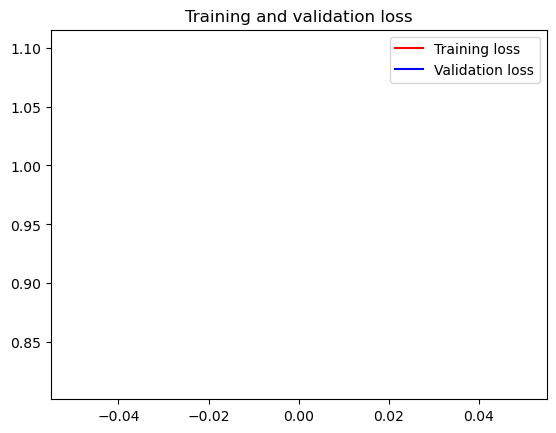

<Figure size 640x480 with 0 Axes>

In [22]:
#학습 성능 그래프화
plot_acc_model(acc, val_acc, epochs)
plot_loss_model(loss, val_loss, epochs)

In [23]:
#예측 값 뽑기
y_pred = model_vgg16.predict(X_test)

13/13 [==============================] - 3s 237ms/step


In [24]:
print(y_pred)

[[0.39376247 0.5022282  0.05917282 0.04483662]
 [0.12800212 0.69141096 0.1563826  0.02420434]
 [0.42248765 0.5145381  0.02621443 0.03675985]
 ...
 [0.13275982 0.19236691 0.03127212 0.6436011 ]
 [0.14419727 0.16601479 0.03041565 0.65937227]
 [0.08348279 0.12878962 0.01662253 0.7711051 ]]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


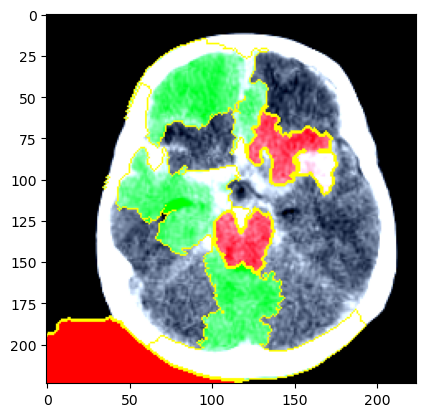

In [25]:
from lime.lime_image import LimeImageExplainer
import matplotlib.pyplot as plt

#예측된 결과중 첫번째 (X_test[0])에다가 LIME(설명가능한 인공지능 기법) 붙이기
explainer = LimeImageExplainer()
image_to_explain = X_test[0]
explanation = explainer.explain_instance(X_test[0].astype('double'), model_vgg16.predict, top_labels=1, hide_color=0, num_samples=1000)

#mask에서 positive_only = True로 하면 긍정적으로 예측에 기여하는 부분만 시각화
#False -> 부정적으로 기여하는 부분도 시각화
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

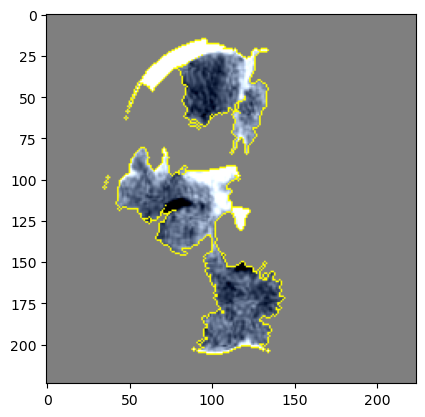

In [26]:
#긍정적으로 기여하는 부분 (슈퍼픽셀)만 시각화
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

/Users/sunyoung-park/miniforge3/envs/tf_gpu/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/sunyoung-park/miniforge3/envs/tf_gpu/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|████████████████                | 2/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|████████████████████████| 4/4 [00:28<00:00,  4.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 5it [00:39, 13.22s/it]                                     


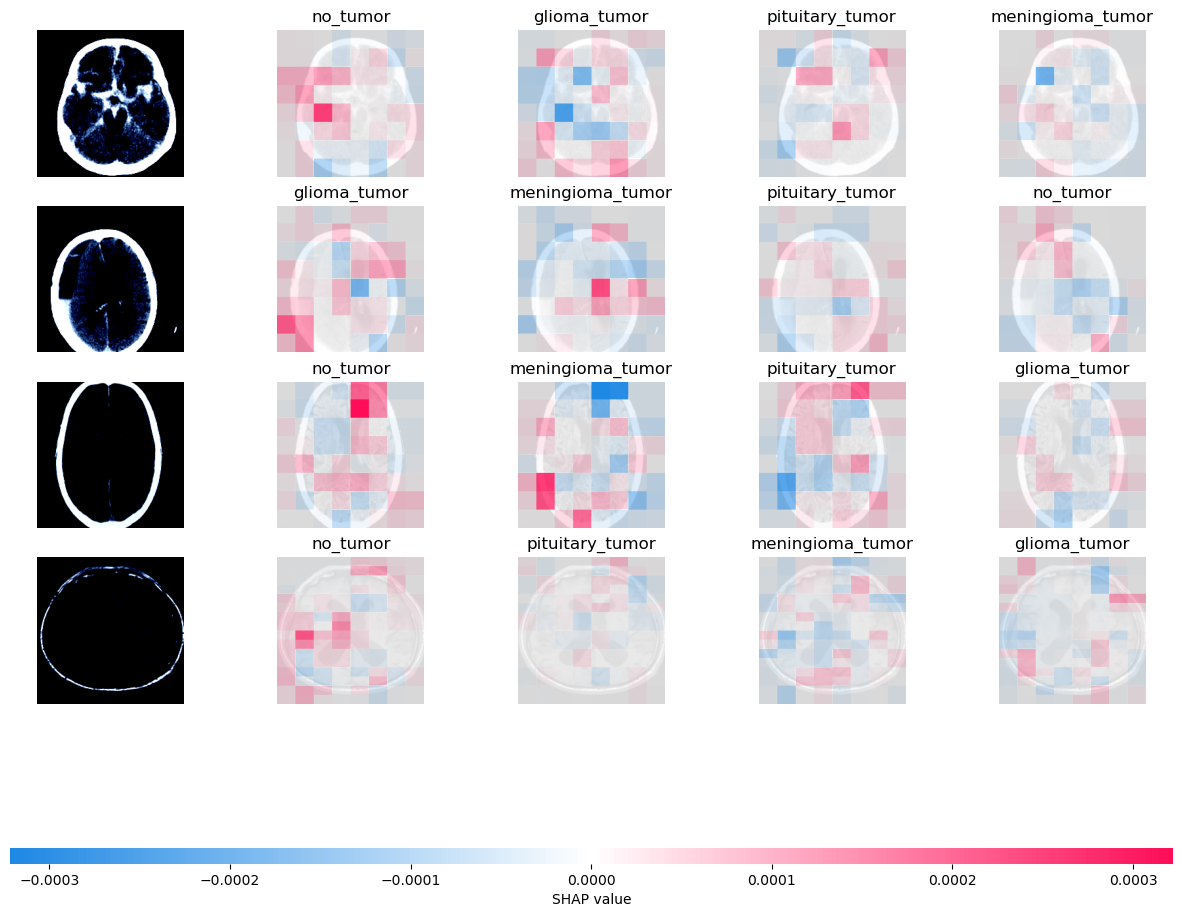

In [27]:
import shap

#shap도 비슷 (빨간색 : 긍정적, 파란색: 부정적)
shap.initjs()
masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)
explainer = shap.Explainer(model_vgg16, masker, output_names=classes)
explainer
shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])
shap_values.shape
shap.image_plot(shap_values)